In [84]:
import pandas as pd
import gensim
from konlpy.tag import Komoran
import sentencepiece as spm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='Malgun Gothic',
              rc=custom_params)

In [47]:
# 자동차 사전 데이터 불러오기
def load_car_dic():
    car_dic_file = open('carDic.txt','r',encoding='utf8')
    car_dic = set(car_dic_file.read().split('\n'))
    return car_dic

car_dic = load_car_dic()
print(len(car_dic))

1433


In [48]:
memo_data = pd.read_csv('car_inspect_info.tsv', sep='\t', lineterminator='\r')
memo_data = memo_data.drop(columns=['inspect_id', 'car_id', 'price']) # drop columns
memo_data = memo_data.dropna() # drop nan row
print(len(memo_data))
memo_data.head()

254142


,inspect_at,inspect_type,description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환


### sentences 전처리

In [49]:
with open('car_info_description.txt','w',encoding='utf8') as w, open('KCC150_100k.txt','r',encoding='utf8') as corpus:
    w.write('\n'.join(memo_data['description']))
    for idx, snt in enumerate(corpus.readlines()):
        w.write(snt)

In [50]:
spm.SentencePieceTrainer.Train(f'--input=car_info_description.txt --model_prefix=description --vocab_size=6000')
sp = spm.SentencePieceProcessor()
vocab_file = 'description.model'
sp.load(vocab_file)

True

In [51]:
def to_token(df, col):

    morph_description = []
    for _, row in df.iterrows():
        memo = row[col]
        sp_out = sp.encode_as_pieces(memo.replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( '))
        morph_description.append(' '.join([token.replace('▁','') for token in sp_out]))

    df["subword_description"] = morph_description
    return df

memo_data = to_token(memo_data, "description")
memo_data.head()

,inspect_at,inspect_type,description,subword_description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [53]:
sentences = list(memo_data['subword_description'])
sentences = [line.split() for line in sentences]

#### FastText 모델사용

In [54]:
model = gensim.models.fasttext.FastText(vector_size=300, window=5, min_count=1)
model.build_vocab(sentences)
model.train(sentences, total_examples=len(sentences), epochs=10)

(13147939, 17214490)

In [55]:
model.wv.most_similar('타이어', topn=10)

[('앞타이어', 0.8547701239585876),
 ('이어', 0.8504299521446228),
 ('타이어펑크', 0.8404929041862488),
 ('후좌타이어', 0.8082572817802429),
 ('전좌타이어', 0.7912278771400452),
 ('후우타이어', 0.7785308361053467),
 ('전우타이어', 0.775689959526062),
 ('타이어공기압', 0.7028477787971497),
 ('타이어테크', 0.6737075448036194),
 ('김대중타이어', 0.6582560539245605)]

In [56]:
model.wv.most_similar('경고등', topn=10)

[('통합경고등', 0.8106489777565002),
 ('공기압경고등', 0.7518486380577087),
 ('경고', 0.6846908330917358),
 ('라이트경고등', 0.664237380027771),
 ('엔진체크등', 0.6376634240150452),
 ('기억', 0.6001758575439453),
 ('고장코드', 0.5991212129592896),
 ('체크', 0.5374683141708374),
 ('과거', 0.5029752850532532),
 ('코드', 0.4666535258293152)]

In [114]:
model.wv.most_similar('범퍼', topn=10)

[('뒷범퍼', 0.8122793436050415),
 ('앞범퍼', 0.7926440834999084),
 ('휀다', 0.7617827653884888),
 ('언더커버', 0.6781392097473145),
 ('판넬', 0.6512221693992615),
 ('하단', 0.6045545339584351),
 ('휀', 0.5950325727462769),
 ('손상확인', 0.5937480926513672),
 ('컴파운드', 0.5548393726348877),
 ('뒷문', 0.5440701842308044)]

In [58]:
# 유사도가 평균값 이상인 것만 선택 하는 함수
def exclusion(word_list):

    count = sum([score for _, score in word_list])
    avg = count / len(word_list)
  
    up_word = []
    for w, s in word_list:
        if s > avg:
            up_word.append(w)
  
    return up_word

In [74]:
light = model.wv.most_similar('라이트', topn=20)
light_word = exclusion(light)
light = model.wv.most_similar('전구', topn=20)
light_word.extend(exclusion(light))

light_word.append('라이트')
light_word.append('전구')

light_word = set(light_word)

error = model.wv.most_similar('경고등', topn=10)
error_word = exclusion(error)
error_word.append('경고등')

print(light_word)
print('')
print(error_word)

{'주행등', '전구', '방향지시등', '안개등', '브레이크전구', '라이트전구', '브레이크등', '보조제동등', '전조등', '헤드라이트', '미등', '데이라이트', '백색더블', '하향등', '라이트', '주간주행등'}

['통합경고등', '공기압경고등', '경고', '라이트경고등', '엔진체크등', '경고등']


In [60]:
# 매핑 테이블 작성
mapping_table = {'내비게이션':'네비게이션', '내비':'네비게이션', '네비':'네비게이션', \
                  '딜리버리':'탁송', '탁송비':'탁송', \
                  '브레이크 오일':'브레이크액', '브레이크오일':'브레이크액', \
                  '라디오':'오디오'}

# "라이트" 관련 단어 매핑 테이블 추가
light_mapping = dict()
for word in light_word:
    light_mapping[word] = '라이트'

mapping_table.update(light_mapping)

# "경고등" 관련 단어 매핑 테이블 추가
error_mapping = dict()
for word in error_word:
    error_mapping[word] = '경고등'

mapping_table.update(error_mapping)

print(mapping_table)

{'내비게이션': '네비게이션', '내비': '네비게이션', '네비': '네비게이션', '딜리버리': '탁송', '탁송비': '탁송', '브레이크 오일': '브레이크액', '브레이크오일': '브레이크액', '라디오': '오디오', '주행등': '라이트', '전구': '라이트', '방향지시등': '라이트', '안개등': '라이트', '브레이크전구': '라이트', '라이트전구': '라이트', '브레이크등': '라이트', '보조제동등': '라이트', '전조등': '라이트', '헤드라이트': '라이트', '미등': '라이트', '데이라이트': '라이트', '백색더블': '라이트', '하향등': '라이트', '라이트': '라이트', '주간주행등': '라이트', '통합경고등': '경고등', '공기압경고등': '경고등', '경고': '경고등', '라이트경고등': '경고등', '엔진체크등': '경고등', '경고등': '경고등'}


In [116]:
bumper = model.wv.most_similar('범퍼', topn=20)
bumper_word = exclusion(bumper)
bumper_word.append('범퍼')
bumper_word = set(bumper_word)
print(bumper_word)

bumper_mapping = dict()
for word in bumper_word:
    bumper_mapping[word] = '범퍼'

mapping_table.update(bumper_mapping)

{'손상확인', '범퍼', '휀다', '언더커버', '하단', '휀', '앞범퍼', '뒷범퍼', '판넬'}


In [117]:
#total 45 category
category = set(memo_data['inspect_type'])
print(len(category))

45


In [118]:
print(category)

{'기타', '사고수리', 'CSA_A/S', '얼라이먼트', '운영상태점검', '타이어일반', '장애처리', '후패드', '타이어수리(전좌)', 'TCS', '전패드', '엔진오일', '휠캡', '타이어교체(후좌)', '에어컨필터', 'CSA', '타이어교체(전좌)', '타이어교체(전우)', '하이패스', 'V리브드벨트', '재충전배터리', '컴파운드', '사고조사', '주차장위치', '키케이블', '미션오일', '브레이크액', '블랙박스', '점화플러그', '와이퍼', '정기검사', '배터리', '상품화점검', '타이어수리(전우)', '일반수리', '타이어교체(후우)', '전압관리', '후방카메라', '아이들러베어링', '출장점검', '세차점검', '네비게이션', '타이어수리(후좌)', '타이어수리(후우)', '브레이크'}


In [119]:
def noun_phrase(words):
    result = []

    for index, token in enumerate(words):
        if (token in car_dic) or (token in category):
            
            if (''.join(words[index : index +2]) in car_dic) or (''.join(words[index : index +2]) in category):
                result.append(''.join(words[index : index +2]))
            
            result.append(token)
    return result

def find_category(row):
   
    line = row['description'].replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( ')
    car_token = noun_phrase(line.upper().split())
 
    car_token.extend(noun_phrase(row['subword_description'].upper().split()))
    return set(car_token)

In [120]:
subword_list = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '사고수리':
        car_words = find_category(row) 
    
        if len(car_words) >= 1: 
            subword_list.extend(car_words)

subword_list = [subword for subword in subword_list if subword != '']
subword_counter = Counter(subword_list) 
subword_sort = sorted(subword_counter.items(), key=lambda x:x[1], reverse=True)
subword_top20 = [(key, value) for key, value in subword_sort[:20]]

print(subword_top20)

[('범퍼', 256), ('도어', 107), ('사이드', 68), ('사고수리', 64), ('월', 51), ('사고조사', 6), ('컴파운드', 6), ('필러', 5), ('커버', 5), ('안개등', 2), ('암', 2), ('몰딩', 2), ('루프', 1), ('유리', 1), ('센서', 1), ('볼', 1), ('손잡이', 1), ('타이어', 1), ('버스', 1), ('터미널', 1)]


In [121]:
def re_ranking(word_list):

    max_word = (None, -99)
    for word in word_list:
        if word in mapping_table:
            word = mapping_table.get(word)

        if subword_counter[word] > max_word[1]:
            max_word = (word, subword_counter[word])

    return max_word[0]

In [122]:
category_count = 0
recategory_count = 0
recategory = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '사고수리':
        carWords = find_category(row) 
        recat = re_ranking(carWords)
        recategory.append(recat)
    
        category_count += 1
        if recat != None:
            recategory_count += 1 

    else:
        recategory.append(None)

memo_data['recategory'] = recategory 

memo_data = memo_data[['inspect_at', 'inspect_type','recategory','description','subword_description']]

memo_data.head()

,inspect_at,inspect_type,recategory,description,subword_description
0,2020-03-09,타이어수리(후우),None,조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,None,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,None,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,None,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,None,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [123]:
recategory_counter = Counter(recategory)
recategory_counter_sorted = sorted(recategory_counter.items(), key=lambda x:x[1], reverse=True)
recategory_top20 = [(key, value) for key, value in recategory_counter_sorted[:21]]
print(recategory_top20)

[(None, 253699), ('범퍼', 256), ('도어', 99), ('사이드', 43), ('사고수리', 19), ('월', 9), ('사고조사', 6), ('필러', 3), ('컴파운드', 3), ('암', 2), ('루프', 1), ('커버', 1), ('버스', 1)]


In [124]:
normal = memo_data.loc[memo_data['inspect_type'] == '사고수리'].copy()
normal['dates'] = pd.to_datetime(normal['inspect_at'], format='%Y-%m-%d', errors='raise')

normal.head()

,inspect_at,inspect_type,recategory,description,subword_description,dates
24,2020-02-28,사고수리,None,@40하9707/스포티지/평창am호텔정문앞/69069km #업무요청 -차케어 김수로...,@ 40 하 97 07 스포티지 평창 a m 호텔 정 문 앞 6 90 69 km ...,2020-02-28
61,2020-01-14,사고수리,None,우측 사이드미러 교체 완료(스피드메이트 이마트속초점),우측 사이드미러 교체 완료 ( 스피드메이트 이마트 속 초 점 ),2020-01-14
801,2020-09-01,사고수리,None,테스트,테스트,2020-09-01
936,2020-04-14,사고수리,None,차량상태확인,차량 상태 확인,2020-04-14
1291,2020-12-01,사고수리,None,컨트롤메뉴얼 부품대 비용결제,컨트롤 메 뉴 얼 부품대 비용 결제,2020-12-01


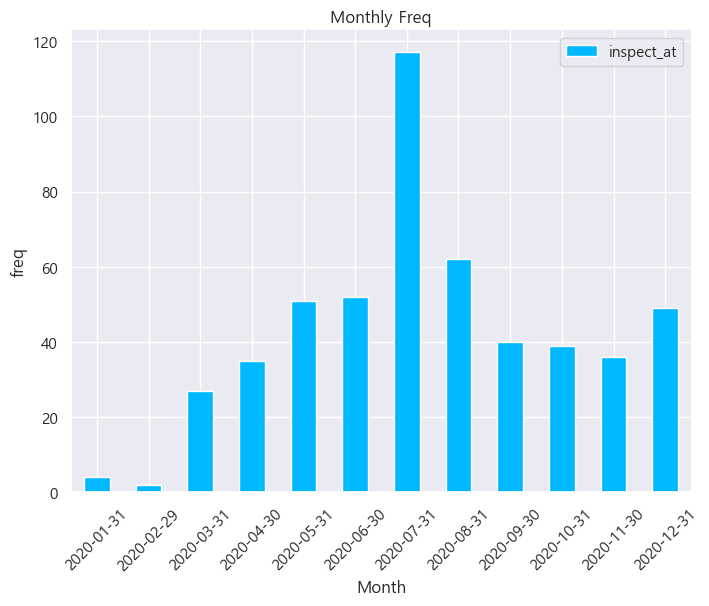

In [125]:
monthly = normal.groupby(pd.Grouper(key='dates', freq='M')).count()
monthly = monthly['inspect_at']
monthly = monthly.reset_index()
monthly['dates_str'] = monthly['dates'].apply(lambda x: str(x)[:10])

plt.rcParams["figure.figsize"] = (8, 6)
monthly.plot(x='dates_str',y='inspect_at', color='#00B8FF', kind='bar')

plt.xticks(rotation=45)
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')

plt.show()

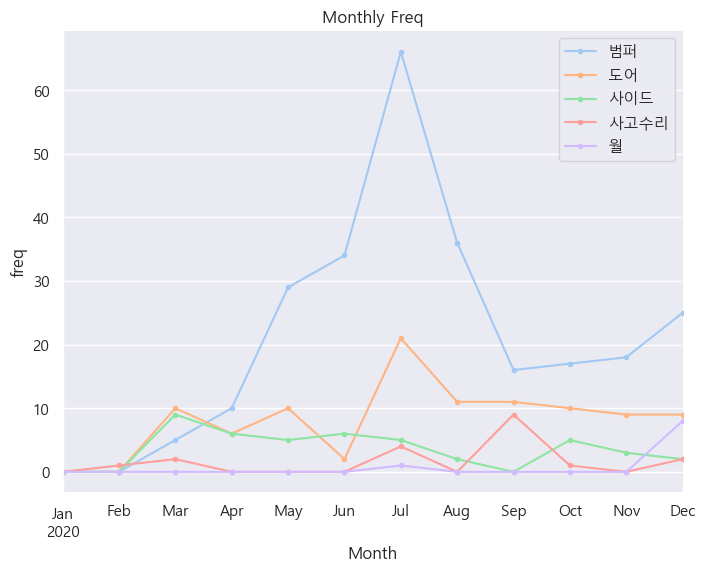

In [126]:
# recategory freq Top 5
temp = pd.DataFrame()
for word, count in recategory_top20[1:6]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.show()

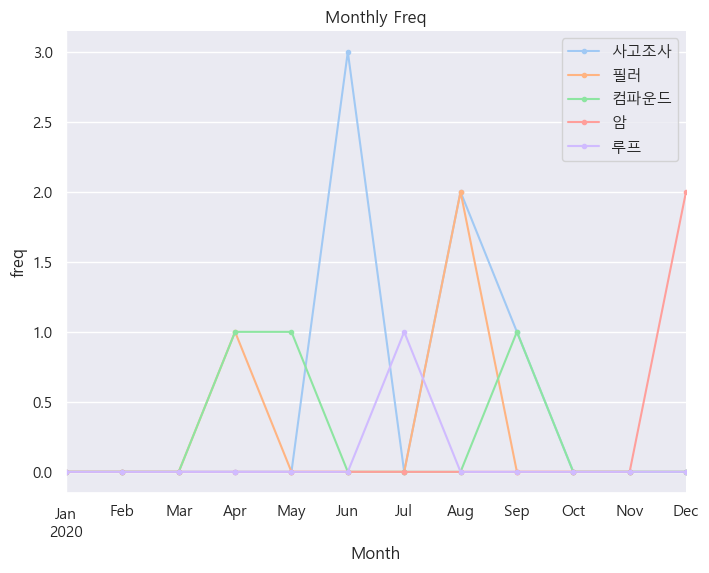

In [127]:
# recategory freq Top 6-10
temp = pd.DataFrame()
for word, count in recategory_top20[6:11]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.show()